Visualizing Sample Data...


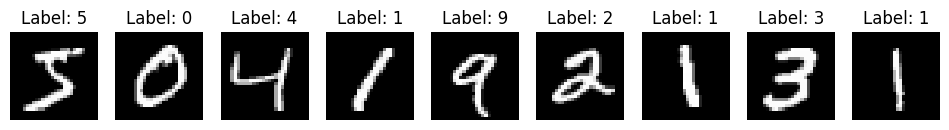

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load the MNIST Dataset

data_dir = "./data"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root=data_dir, train=True, transform=transform, download=False)
test_dataset = datasets.MNIST(root=data_dir, train=False, transform=transform, download=False)

# Convert datasets to loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# Visualize sample data
def visualize_samples(dataset, num_samples=9):
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))
    for i, ax in enumerate(axes):
        image, label = dataset[i]
        ax.imshow(image.squeeze(), cmap="gray")
        ax.set_title(f"Label: {label}")
        ax.axis("off")
    plt.show()

print("Visualizing Sample Data...")
visualize_samples(train_dataset)

In [2]:
# Flatten dataset to use with MLP
def flatten_data(loader):
    data, labels = [], []
    for images, lbls in loader:
        data.append(images.view(images.size(0), -1).numpy())
        labels.append(lbls.numpy())
    return np.vstack(data), np.hstack(labels)

X_train, y_train = flatten_data(train_loader)
X_test, y_test = flatten_data(test_loader)


In [3]:
# Define the MLP Classifier
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
# should work with gpu but i dont have one
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Helper function to train and evaluate the model
def train_and_evaluate(model, train_loader, test_loader, num_epochs=5, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)
    
    # Perform MLP
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.view(images.size(0), -1).to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

    # Evaluate
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.view(images.size(0), -1).to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")
    return accuracy

In [4]:
# Train and evaluate MLP on original data
input_size = 28 * 28
hidden_size = 128
output_size = 10

print("Training MLP on Original Data")
mlp_original = MLP(input_size, hidden_size, output_size)
start_time_original = time.time()
accuracy_original = train_and_evaluate(mlp_original, train_loader, test_loader)
time_original = time.time() - start_time_original


Training MLP on Original Data...
Epoch [1/5], Loss: 0.3893
Epoch [2/5], Loss: 0.2037
Epoch [3/5], Loss: 0.1436
Epoch [4/5], Loss: 0.1162
Epoch [5/5], Loss: 0.1002
Accuracy: 0.9644


In [5]:
# Apply PCA using sklearn

n_components = 50
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Convert PCA data to PyTorch loaders
train_pca_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(X_train_pca, dtype=torch.float32), torch.tensor(y_train)),
    batch_size=64,
    shuffle=True
)

test_pca_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.tensor(X_test_pca, dtype=torch.float32), torch.tensor(y_test)),
    batch_size=64,
    shuffle=False
)

# Train and evaluate MLP on PCA-reduced data
print("Training MLP on PCA-Reduced Data")
mlp_pca = MLP(n_components, hidden_size, output_size)
start_time_pca = time.time()
accuracy_pca = train_and_evaluate(mlp_pca, train_pca_loader, test_pca_loader)
time_pca = time.time() - start_time_pca

Applying PCA to reduce dimensionality...
Training MLP on PCA-Reduced Data...
Epoch [1/5], Loss: 0.3618
Epoch [2/5], Loss: 0.1344
Epoch [3/5], Loss: 0.0935
Epoch [4/5], Loss: 0.0734
Epoch [5/5], Loss: 0.0606
Accuracy: 0.9769


In [6]:
# Compare Results
print("\nComparison of Results:")
print(f"Accuracy on Original Data: {accuracy_original:.4f}")
print(f"Accuracy on PCA-Reduced Data: {accuracy_pca:.4f}")
print(f"Time taken on Original Data: {time_original:.2f} seconds")
print(f"Time taken on PCA-Reduced Data: {time_pca:.2f} seconds")



Comparison of Results:
Accuracy on Original Data: 0.9644
Accuracy on PCA-Reduced Data: 0.9769
Time taken on Original Data: 40.17 seconds
Time taken on PCA-Reduced Data: 5.82 seconds
